In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
books_df = pd.read_csv('/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/Dataset/Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
users_df = pd.read_csv('/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/Dataset/url.html', sep=';', encoding='latin-1', on_bad_lines='skip')
ratings_df = pd.read_csv('/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/Dataset/Ratings.csv', sep=';', encoding='latin-1', on_bad_lines='skip')

In [3]:
# Display basic information about the datasets
print("Books dataset shape:", books_df.shape)
print("Users dataset shape:", users_df.shape)
print("Ratings dataset shape:", ratings_df.shape)

# Display the first few rows of each dataset
print("\nBooks dataset:")
print(books_df.head())
print("\nUsers dataset:")
print(users_df.head())
print("\nRatings dataset:")
print(ratings_df.head())

# Check for missing values
print("\nMissing values in Books dataset:")
print(books_df.isnull().sum())
print("\nMissing values in Users dataset:")
print(users_df.isnull().sum())
print("\nMissing values in Ratings dataset:")
print(ratings_df.isnull().sum())

Books dataset shape: (271379, 5)
Users dataset shape: (1, 2)
Ratings dataset shape: (1149780, 3)

Books dataset:
         ISBN                                              Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 Author  Year                Publisher  
0    Mark P. O. Morford  2002  Oxford University Press  
1  Richard Bruce Wright  2001    HarperFlamingo Canada  
2          Carlo D'Este  1991          HarperPerennial  
3      Gina Bari Kolata  1999     Farrar Straus Giroux  
4       E. J. W. Barber  1999   W. W. Norton & Company  

Users dataset:
  <html lang="en-CA"> <head> <meta content="origin" name="referrer">  <script nonce="zSwLAYREmHPKau2_PPh8lQ">window.goog


Ratings statistics:
count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Rating, dtype: float64


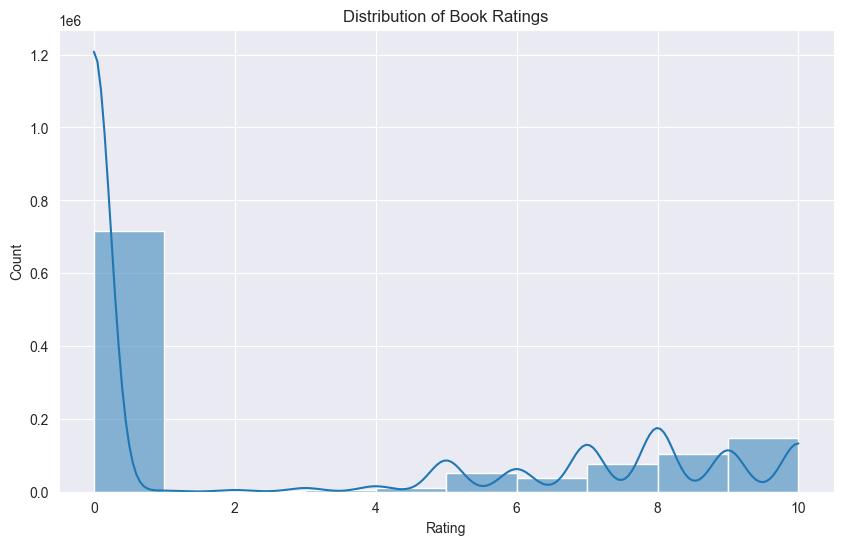

In [4]:
# Basic statistics of ratings
print("\nRatings statistics:")
print(ratings_df['Rating'].describe())

# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['Rating'], bins=10, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [5]:
# Top 10 most rated books
top_books = ratings_df['ISBN'].value_counts().head(10)
top_books_info = books_df[books_df['ISBN'].isin(top_books.index)][['ISBN', 'Title', 'Author']]
print("\nTop 10 most rated books:")
print(top_books_info)


Top 10 most rated books:
            ISBN                                            Title  \
26    0971880107                                      Wild Animus   
118   0671027360                                  Angels & Demons   
305   044023722X                                  A Painted House   
356   0142001740                          The Secret Life of Bees   
408   0316666343                        The Lovely Bones: A Novel   
522   0312195516              The Red Tent (Bestselling Backlist)   
748   0385504209                                The Da Vinci Code   
1105  0060928336  Divine Secrets of the Ya-Ya Sisterhood: A Novel   
1922  067976402X                           Snow Falling on Cedars   

              Author  
26      Rich Shapero  
118        Dan Brown  
305     John Grisham  
356    Sue Monk Kidd  
408     Alice Sebold  
522    Anita Diamant  
748        Dan Brown  
1105   Rebecca Wells  
1922  David Guterson  


In [6]:
# Preprocessing steps
# 1. Remove users with less than 5 ratings
user_counts = ratings_df['User-ID'].value_counts()
valid_users = user_counts[user_counts >= 5].index
ratings_df_filtered = ratings_df[ratings_df['User-ID'].isin(valid_users)]

# 2. Remove books with less than 10 ratings
book_counts = ratings_df_filtered['ISBN'].value_counts()
valid_books = book_counts[book_counts >= 10].index
ratings_df_filtered = ratings_df_filtered[ratings_df_filtered['ISBN'].isin(valid_books)]

# 3. Merge books and ratings data
merged_df = pd.merge(ratings_df_filtered, books_df[['ISBN', 'Title', 'Author', 'Year', 'Publisher']], on='ISBN')

print("\nShape of filtered and merged dataset:", merged_df.shape)



Shape of filtered and merged dataset: (448673, 7)


In [7]:
# 4. Split data into train and test sets
train_data, test_data = train_test_split(merged_df, test_size=0.2, random_state=42)

print("\nShape of training data:", train_data.shape)
print("Shape of test data:", test_data.shape)

# Save preprocessed data
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("\nPreprocessing completed. Train and test data saved.")


Shape of training data: (358938, 7)
Shape of test data: (89735, 7)

Preprocessing completed. Train and test data saved.


FAISS Encoding 

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm


In [9]:
# Load the preprocessed data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [10]:
# Combine train and test data for embedding generation
all_books = pd.concat([train_data, test_data])['Title'].unique()

# Load pre-trained model for text embedding
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Generate embeddings for all books
book_embeddings = {}
for book in tqdm(all_books):
    book_embeddings[book] = get_embedding(book)

# Save embeddings
import pickle
with open('book_embeddings.pkl', 'wb') as f:
    pickle.dump(book_embeddings, f)

print("Book embeddings generated and saved.")

/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 14024/14024 [01:19<00:00, 176.06it/s]


Book embeddings generated and saved.


In [11]:
import numpy as np
import faiss

# Load book embeddings
with open('book_embeddings.pkl', 'rb') as f:
    book_embeddings = pickle.load(f)

# Prepare data for FAISS
book_titles = list(book_embeddings.keys())
embeddings = np.array(list(book_embeddings.values())).astype('float32')

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

# Save FAISS index
faiss.write_index(index, 'book_index.faiss')

print("FAISS index created and saved.")

FAISS index created and saved.


In [15]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.llms import HuggingFacePipeline

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load GPT-2 model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15,
    device=0 if device == "cuda" else -1  # Use GPU if available
)

# Create LangChain LLM
llm = HuggingFacePipeline(pipeline=pipe)

# Define a prompt template
template = """
Based on the user's interests and the following similar books, provide a personalized book recommendation:

User interests: {interests}

Similar books:
{similar_books}

Recommendation:
"""

prompt = PromptTemplate(template=template, input_variables=["interests", "similar_books"])

# Create the LLM chain
llm_chain = LLMChain(prompt=prompt, llm=llm)

# Function to generate recommendation
def generate_recommendation(interests, similar_books):
    similar_books_str = "\n".join(similar_books)
    result = llm_chain.run(interests=interests, similar_books=similar_books_str)
    return result

# Example usage
user_interests = "I enjoy comedy, romance that makes my relaxed."
similar_books = [
    "Dune by Frank Herbert",
    "Neuromancer by William Gibson",
    "The Left Hand of Darkness by Ursula K. Le Guin"
]

recommendation = generate_recommendation(user_interests, similar_books)
print("Recommendation:")
print(recommendation)

Using device: cpu


/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Recommendation:

Based on the user's interests and the following similar books, provide a personalized book recommendation:

User interests: I enjoy science fiction novels with natural world building and philosophical themes.

Similar books:
Dune by Frank Herbert
Neuromancer by William Gibson
The Left Hand of Darkness by Ursula K. Le Guin

Recommendation:
 (1) This is not recommended as it may contain spoilers for some readers; otherwise you will be disappointed in your purchase!


In [17]:
# Function to generate recommendation
def generate_recommendation(interests, similar_books):
    similar_books_str = "\n".join(similar_books)
    result = llm_chain.run(interests=interests, similar_books=similar_books_str)
    return result

# Example usage
user_interests = "I enjoy light-hearted romantic comedies that make me feel relaxed and happy."
similar_books = [
    "Bridget Jones's Diary by Helen Fielding",
    "The Rosie Project by Graeme Simsion",
    "The Hating Game by Sally Thorne",
    "Red, White & Royal Blue by Casey McQuiston",
    "The Flatshare by Beth O'Leary"
]

recommendation = generate_recommendation(user_interests, similar_books)
print("Recommendation:")
print(recommendation)

Recommendation:

Based on the user's interests and the following similar books, provide a personalized book recommendation:

User interests: I enjoy light-hearted romantic comedies that make me feel relaxed and happy.

Similar books:
Bridget Jones's Diary by Helen Fielding
The Rosie Project by Graeme Simsion
The Hating Game by Sally Thorne
Red, White & Royal Blue by Casey McQuiston
The Flatshare by Beth O'Leary

Recommendation:
 'I like this series because of its unique characters.' [Reviews]


In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.llms import HuggingFacePipeline

# Load the training data
train_data = pd.read_csv('train_data.csv')

# Create a content column for TF-IDF
train_data['content'] = train_data['Title'] + ' ' + train_data['Author'] + ' ' + train_data['Publisher']

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(train_data['content'])

# Load GPT-2 model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
)

# Create LangChain LLM
llm = HuggingFacePipeline(pipeline=pipe)

# Define a prompt template
template = """
Based on the user's interests, provide a personalized book recommendation:

User interests: {interests}

Top rated similar books:
{similar_books}

Recommendation:
"""

prompt = PromptTemplate(template=template, input_variables=["interests", "similar_books"])

# Create the LLM chain
llm_chain = LLMChain(prompt=prompt, llm=llm)

def get_book_recommendations(user_interests, top_n=5):
    # Convert user interests to TF-IDF vector
    user_vector = tfidf.transform([user_interests])
    
    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(user_vector, tfidf_matrix).flatten()
    
    # Get top similar books, ensuring uniqueness and filtering out low ratings (e.g., 0)
    similar_indices = np.argsort(cosine_similarities)[-top_n:][::-1]
    
    # Create a set to track unique titles and avoid duplicates in recommendations
    unique_titles = set()
    recommended_books = []

    for index in similar_indices:
        book = train_data.iloc[index]
        if book['Title'] not in unique_titles and book['Rating'] > 0:  # Filter out duplicates and low ratings
            unique_titles.add(book['Title'])
            recommended_books.append(book)

        if len(recommended_books) >= top_n:  # Stop if we have enough recommendations
            break
    
    # Format similar books for the prompt
    similar_books_str = "\n".join(f"{book['Title']} by {book['Author']} ({book['Year']}, {book['Publisher']}, Rating: {book['Rating']})" 
                                  for book in recommended_books)
    
    # Generate recommendation
    result = llm_chain.run(interests=user_interests, similar_books=similar_books_str)
    return result

# Example usage
user_interests = "I enjoy light-hearted romantic comedies that make me feel relaxed and happy."
recommendation = get_book_recommendations(user_interests)
print("Recommendation:")
print(recommendation)

/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Recommendation:

Based on the user's interests, provide a personalized book recommendation:

User interests: I enjoy light-hearted romantic comedies that make me feel relaxed and happy.

Top rated similar books:
Feel the Fear and Do It Anyway by Susan Jeffers (1988, Ballantine Books, Rating: 6)

Recommendation:
 "The Great American Novelist" - Love is Real – My wife reads it every day as we watch The Big Bang Theory this week! This will be her first time reading something so original but also very accessible for those with children who want to read more complex stories about life in our own culture than they've ever seen before; while she does not have any real personal interest from now on though...it can't hurt!!! Recommended Reads at Age 5 or Older : You probably know how much love you need when your child tells them their dad was killed off because of his past actions -- no one wants him back anymore after being born!! If someone says he didn´t do anything wrong then maybe some kid

In [25]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.llms import HuggingFacePipeline

# Load the training data
train_data = pd.read_csv('train_data.csv')

# Data Enrichment: Add a genre column (you'll need to implement a method to determine genres)
def determine_genre(title, author):
    # This is a placeholder function. In a real scenario, you'd use a more sophisticated method
    # to determine the genre based on the title, author, or additional data
    genres = ['Romance', 'Comedy', 'Sci-Fi', 'Mystery', 'Thriller', 'Fantasy', 'Non-Fiction']
    return np.random.choice(genres)  # For demonstration, we're randomly assigning genres

train_data['Genre'] = train_data.apply(lambda row: determine_genre(row['Title'], row['Author']), axis=1)

# Improve Content Matching: Enhance TF-IDF vectorization
train_data['content'] = train_data['Title'] + ' ' + train_data['Author'] + ' ' + train_data['Publisher'] + ' ' + train_data['Genre']

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(train_data['content'])

# Load GPT-2 model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
)

# Create LangChain LLM
llm = HuggingFacePipeline(pipeline=pipe)

# Define a prompt template
template = """
Based on the user's interests, provide a personalized book recommendation:

User interests: {interests}

Top rated similar books:
{similar_books}

Recommendation:
"""

prompt = PromptTemplate(template=template, input_variables=["interests", "similar_books"])

# Create the LLM chain
llm_chain = LLMChain(prompt=prompt, llm=llm)

def get_book_recommendations(user_interests, top_n=10):
    # Convert user interests to TF-IDF vector
    user_vector = tfidf.transform([user_interests])
    
    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(user_vector, tfidf_matrix).flatten()
    
    # Weighted Scoring: Combine similarity score with book rating
    weighted_scores = cosine_similarities * train_data['Rating'].values
    
    # Get top similar books, ensuring uniqueness and filtering out low ratings
    similar_indices = np.argsort(weighted_scores)[-top_n*2:][::-1]  # Get more books initially
    
    # Create a set to track unique titles and avoid duplicates in recommendations
    unique_titles = set()
    recommended_books = []

    for index in similar_indices:
        book = train_data.iloc[index]
        if book['Title'] not in unique_titles and book['Rating'] > 0:  # Filter out duplicates and low ratings
            unique_titles.add(book['Title'])
            recommended_books.append(book)

        if len(recommended_books) >= top_n:  # Stop if we have enough recommendations
            break
    
    # Format similar books for the prompt
    similar_books_str = "\n".join(f"{book['Title']} by {book['Author']} ({book['Year']}, {book['Publisher']}, Rating: {book['Rating']}, Genre: {book['Genre']})" 
                                  for book in recommended_books)
    
    # Generate recommendation
    result = llm_chain.run(interests=user_interests, similar_books=similar_books_str)
    return result

# Function to get book recommendations
def recommend_books(user_interests):
    recommendation = get_book_recommendations(user_interests)
    print("Recommendation:")
    print(recommendation)

# Now you can use this function with any user interests
# Example usage:

# recommend_books("I'm looking for historical fiction set in ancient Rome.")
# recommend_books("I want a thriller that keeps me on the edge of my seat.")

/Users/abiwaqasyasir/Desktop/UWaterloo_Academics/ML_Work/Recommender/pythonProject/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [26]:
recommend_books("I enjoy science fiction novels with complex world-building and philosophical themes.")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Recommendation:

Based on the user's interests, provide a personalized book recommendation:

User interests: I enjoy science fiction novels with complex world-building and philosophical themes.

Top rated similar books:
The Demon-Haunted World: Science As a Candle in the Dark by Carl Sagan (1997, Ballantine Books, Rating: 10, Genre: Romance)
N-Space by Larry Niven (1991, Tor Science Fiction, Rating: 10, Genre: Fantasy)
Simplify Your Life : 100 Ways to Slow Down and Enjoy the Things That Really Matter by Elaine St. James (1994, Hyperion, Rating: 9, Genre: Non-Fiction)
Flashforward by Robert J. Sawyer (2000, Tor Science Fiction, Rating: 9, Genre: Non-Fiction)
The Rowan (Ace Science Fiction) by Anne McCaffrey (1991, ACE Charter, Rating: 10, Genre: Non-Fiction)

Recommendation:
 'Let me know if you like this one.' A lot of authors are getting their recommendations from readers who want more than just good reviews – they're asking for better things that we can do too!


In [27]:
recommend_books("I'm looking for historical fiction set in ancient Rome.")

Recommendation:

Based on the user's interests, provide a personalized book recommendation:

User interests: I'm looking for historical fiction set in ancient Rome.

Top rated similar books:
Silver Pigs: A Detective Novel in Ancient Rome by Lindsey Davis (1992, Fawcett Books, Rating: 10, Genre: Mystery)
ANCIENT EVIL (CHAIN LETTER 2) : ANCIENT EVIL by Christopher Pike (1992, Simon Pulse, Rating: 10, Genre: Thriller)
Who's Looking Out for You? by BILL O'REILLY (2003, Broadway, Rating: 10, Genre: Fantasy)
The First Man in Rome by Colleen McCullough (1991, Avon, Rating: 10, Genre: Mystery)
Set This House in Order: A Romance of Souls by Matt Ruff (2003, HarperCollins, Rating: 10, Genre: Romance)
Mexico Set by Len Deighton (1990, Ballantine Books, Rating: 8, Genre: Mystery)
Looking Back by Belva Plain (2001, Delacorte Press, Rating: 10, Genre: Romance)

Recommendation:
- Read this novel first - but if you want to follow your dreams and get better at writing then go read it later or watch an 

In [28]:
recommend_books("I want a thriller that keeps me on the edge of my seat.")

Recommendation:

Based on the user's interests, provide a personalized book recommendation:

User interests: I want a thriller that keeps me on the edge of my seat.

Top rated similar books:
SEAT OF THE SOUL by Gary Zukav (1990, Free Press, Rating: 10, Genre: Mystery)
I Want to Grow Hair, I Want to Grow Up, I Want to Go to Boise (Children Surviving Cancer) by Erma Bombeck (1990, Harper Mass Market Paperbacks, Rating: 10, Genre: Thriller)
I'm the One That I Want by Margaret Cho (2002, Ballantine Books, Rating: 10, Genre: Thriller)
A Pony for Keeps (Pony Pals No. 2) by Jeanne Betancourt (1995, Scholastic, Rating: 10, Genre: Comedy)
Over the Edge by Jonathan Kellerman (1993, Signet Book, Rating: 10, Genre: Mystery)
The Edge by Dick Francis (1989, Putnam Pub Group, Rating: 10, Genre: Thriller)

Recommendation:
"If you need help finding good and affordable workable novels about love or war stories with compelling characters." - John Travolta "You can write great literature in just three sho